## **UBICACION METROBUS - ALCALDIAS**

# **Descripción:**
Desarrollar un pipeline de análisis de datos utilizando los datos abiertos de la Ciudad de México correspondientes a las ubicaciones  
de las unidades del metrobús para que pueda ser consultado mediante un API Rest filtrando por unidad o por alcaldía.  

### Librerias

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

### Diagrama de Solución  
![DiagramaSolucion](DiagramaSolucion.png "Title")

### Modelo de Datos  
![DiagramaSolucion](Imagenes\ModeloDatos.png "Title")

### Crear Tablas SQLite

In [2]:
"""Se establece la conexion con la base de datos y se procede a generar la tablas"""

conx = sqlite3.connect('data.db')					
conx.execute("drop table if exists Vehiculos;")		
conx.execute("""create table Vehiculos (			
vehicle_id int PRIMARY KEY,
vehicle_label float
)""")												

conx.execute("drop table if EXISTS Estaciones;")
conx.execute("""CREATE TABLE Estaciones (
	estacion_id int PRIMARY KEY,
	Estacion varchar(50),
	Longitud float,
	Latitud float,
	Alcaldia varchar(50)
)""")

conx.execute("drop table if exists Ubicaciones;")
conx.execute("""CREATE TABLE Ubicaciones (
id int IDENTITY(1,1) PRIMARY KEY,
vehicle_id int,
estacion_id int,
date_updated datetime,
position_latitude FLOAT,
position_longitude FLOAT,
vehicle_current_status INT,
FOREIGN KEY(vehicle_id) REFERENCES Vehiculos(vehicle_id)
FOREIGN KEY(estacion_id) REFERENCES Estaciones(estacion_id)
)""")
conx.commit()

### Carga de Datos CSV

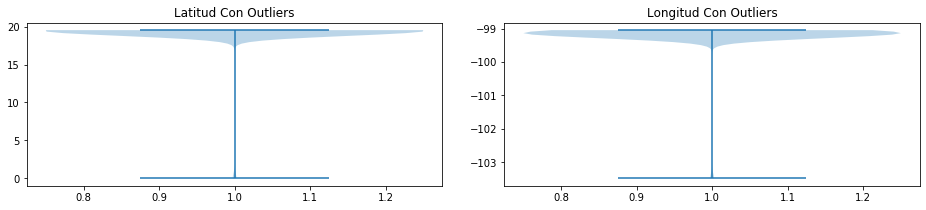

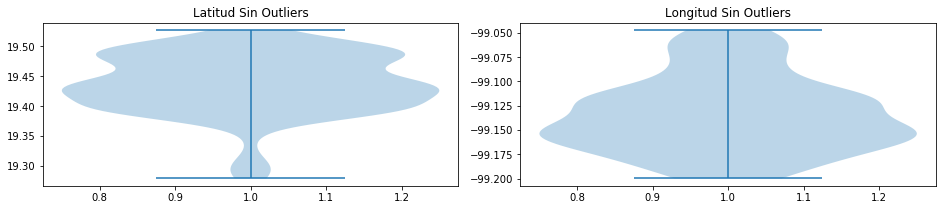

In [3]:
"""Lectura de los datos desde csv"""

df = pd.read_csv('data/prueba_fetchdata_metrobus.csv',encoding='latin-1')   
df.position_latitude = df.position_latitude.astype(float)
df.position_longitude = df.position_longitude.astype(float)

"""Se busca outliers referentes a Latitud y Longitud de los datos y se procede a elminarlos para evitar errores"""

fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize= (16,3))
ax1.violinplot(df.position_latitude)
ax1.set_title("Latitud Con Outliers")
ax2.violinplot(df.position_longitude)
ax2.set_title("Longitud Con Outliers")
plt.subplots_adjust(wspace=0.15)
plt.show()

df = df[df.position_latitude >= df.position_latitude.quantile(0.005)]
df.reset_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize= (16,3))
ax1.violinplot(df.position_latitude)
ax1.set_title("Latitud Sin Outliers")
ax2.violinplot(df.position_longitude)
ax2.set_title("Longitud Sin Outliers")
plt.subplots_adjust(wspace=0.15)
plt.show()

### Armar Tabla Estaciones

In [4]:
"""Armar tabla Estacion mediante el cruce de 2 tablas Alcaldias y Estaciones mediante Pandas"""
estacion = pd.read_csv("data/Estacion.csv")
estacion_alcaldia = pd.read_csv("data/EstacionAlcaldia.csv")
estacion.columns = ['Estacion','Nombre','Longitud','Latitud']
estacion_alcaldia.columns = ['Alcaldia','Nombre','Longitud','Latitud']
estacion = pd.merge(estacion[['Estacion','Longitud','Latitud']],estacion_alcaldia[['Alcaldia','Longitud','Latitud']],how='inner',on=['Longitud','Latitud'])
estacion['Alcaldia'] = estacion.Alcaldia.str.split(' / ',expand=True)[0]
estacion.drop_duplicates(['Estacion'],keep='first',inplace=True)
estacion.reset_index(inplace=True)
estacion.rename(columns={'index':'estacion_id'},inplace=True)
del estacion_alcaldia

In [5]:
"""Armar tabla Vehiculos"""
Vehiculos = df[['vehicle_id','vehicle_label']]

### Alcaldia Correspondiente a cada posición

El flujo para obtener las Alcaldias pertenecientes a la ubicacion de cada MetroBus fue mediante el calculo de la distancia minima entre el punto geografico del MetroBus y las Estaciones de MetroBus. Ya que las estaciones tienen una asignacion de Alcaldia y de esta forma se identifica en que Alcaldia se encuentra el MetroBus

![Rutas](Imagenes\Img.JPG)

In [6]:
"""Calculo de toda las combinanciones de distances para seleccionar la minima distancia y asignar el id_estacion que tiene un 
nombre de la Alcaldia que le corresponde"""
id_estacion = []
for i in range(df.shape[0]):
    l = []
    for j in range(estacion.shape[0]):
        long = df.position_longitude.astype(float)[i]
        lat = df.position_latitude.astype(float)[i]
        a = (long,lat)
        long_al = estacion.Longitud[j]   
        lat_al =  estacion.Latitud[j] 
        b = (long_al,lat_al)
        l.append(distance.euclidean(a, b))
    id_estacion.append(l.index(min(l)))

df['estacion_id'] = id_estacion

### Armar Tabla Ubicaciones

In [7]:
df = df[['vehicle_id','estacion_id','date_updated','position_latitude','position_longitude','vehicle_current_status']]
df.date_updated = pd.to_datetime(df.date_updated)
df.reset_index(inplace=True)
df.rename(columns={'index':'id'},inplace=True)

### Almacenar Bases de Datos

In [8]:
conx = sqlite3.connect('data.db')
conx.commit()
Vehiculos.to_sql('Vehiculos',conx,index=False,if_exists='append')
estacion.to_sql('Estaciones',conx,index=False,if_exists='append')
df.to_sql('Ubicaciones',conx,index=False,if_exists='append')

## Ejecutar GraphQL

In [ ]:
%run main.py

### Ejemplos
![Ejemplo1](Imagenes\Ejem.png)

![Ejemplo2](Imagenes\Ejem2.png)

### Otras formas de calculo de la Alclaida correspondiente a cada posicion y insert de datos

In [ ]:
""""Insert datos a Base de Datos"""
# cols = "`,`".join([str(i) for i in estacion.columns.tolist()])

# # Insert DataFrame recrds one by one.
# for i,row in estacion.iterrows():
#     sql =  "INSERT INTO `Estaciones` (`" +cols + "`) VALUES (" + "?,"*(len(row)-1) + "?)"
#     conx.execute(sql, tuple(row))

# conx.commit()

In [ ]:
# alcaldias = pd.read_csv('data/alcaldias (2).csv',encoding='utf-8')
# l_poligonos = []
# for i in range(alcaldias.shape[0]):
#     xy = np.array(json.loads(alcaldias.geo_shape[9])['coordinates'][0])
#     l = []
#     for e in xy:    
#         l.append(tuple(e))
#     l_poligonos.append(l)
# alcaldias['Poligonos'] = l_poligonos
# alcaldias['latitud'] = alcaldias.geo_point_2d.str.split(',',expand=True)[0].astype(float)
# alcaldias['longitud'] = alcaldias.geo_point_2d.str.split(',',expand=True)[1].astype(float)


In [ ]:
# def is_point_in_path(x: int, y: int, poly) -> bool:
#     # Determine if the point is in the polygon.
#     #
#     # Args:
#     #   x -- The x coordinates of point.
#     #   y -- The y coordinates of point.
#     #   poly -- a list of tuples [(x, y), (x, y), ...]
#     #
#     # Returns:
#     #   True if the point is in the path or is a corner or on the boundary
     
#         num = len(poly)
#         j = num - 1
#         c = False
#         for i in range(num):
#             if (x == poly[i][0]) and (y == poly[i][1]):
#                 # point is a corner
#                 return True
#             if ((poly[i][1] > y) != (poly[j][1] > y)):
#                 slope = (x-poly[i][0])*(poly[j][1]-poly[i][1])-(poly[j][0]-poly[i][0])*(y-poly[i][1])
#                 if slope == 0:
#                     # point is on boundary
#                     return True
#                 if (slope < 0) != (poly[j][1] < poly[i][1]):
#                     c = not c
#             j = i
#         return c

In [ ]:
# l_poligonos = []
# for i in range(alcaldias.shape[0]):
#     x = alcaldias.geo_point_2d.str.split(',',expand=True)[1].astype(float)[i]
#     y = alcaldias.geo_point_2d.str.split(',',expand=True)[0].astype(float)[i]
#     xy = np.array(json.loads(alcaldias.geo_shape[9])['coordinates'][0])
#     l = []
#     for e in xy:    
#         l.append(tuple(e))
#     l_poligonos.append(l)
#     print(is_point_in_path(x,y,l),x,y,alcaldias.nomgeo[i])